# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.

**Brief summary of notebook actions**:

- Download the dog image data and then upload it to an S3 bucket.
- Create a Hyperparameter Tuning job to tune three parameters for an image classification model using transfer learning.
- Create a final model using the best hyperparameter combinations. Also, add debugger and profiler to monitor the training.
- Deploy the resulting model to an endpoint. Query endpoint.
- Delete any active endpoints.



In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug torch torchvision


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import os
import pandas as pd
import matplotlib.pyplot as plt
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, DebuggerHookConfig, ProfilerConfig, FrameworkProfile

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip -o dogImages.zip 

In [5]:
from sagemaker.session import Session
from sagemaker import get_execution_role

role = get_execution_role()
session = sagemaker.Session()

bucket = sagemaker.Session().default_bucket()
print(f'Default s3 bucket : {bucket}')
prefix = "dog-image-data"

s3_path = "dogImages"
role = sagemaker.get_execution_role()
role

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Default s3 bucket : sagemaker-us-east-1-477120104741
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


'arn:aws:iam::477120104741:role/service-role/AmazonSageMaker-ExecutionRole-20240126T115666'

Upload the Dataset to S3

,# train,# valid,# test
Dog Breed,,,
001.Affenpinscher,64,8,8
002.Afghan_hound,58,7,8
003.Airedale_terrier,52,7,6
004.Akita,63,8,8
005.Alaskan_malamute,77,9,10
...,...,...,...
129.Tibetan_mastiff,48,6,6
130.Welsh_springer_spaniel,44,6,5
131.Wirehaired_pointing_griffon,30,4,3



--- Distribution ---

          # train     # valid      # test
count  133.000000  133.000000  133.000000
mean    50.225564    6.278195    6.285714
std     11.863885    1.350384    1.712571
min     26.000000    4.000000    3.000000
25%     42.000000    6.000000    5.000000
50%     50.000000    6.000000    6.000000
75%     61.000000    7.000000    8.000000
max     77.000000    9.000000   10.000000

 --- Split distribution ---


array([[<AxesSubplot:title={'center':'# train'}>,
        <AxesSubplot:title={'center':'# valid'}>],
       [<AxesSubplot:title={'center':'# test'}>, <AxesSubplot:>]],
      dtype=object)

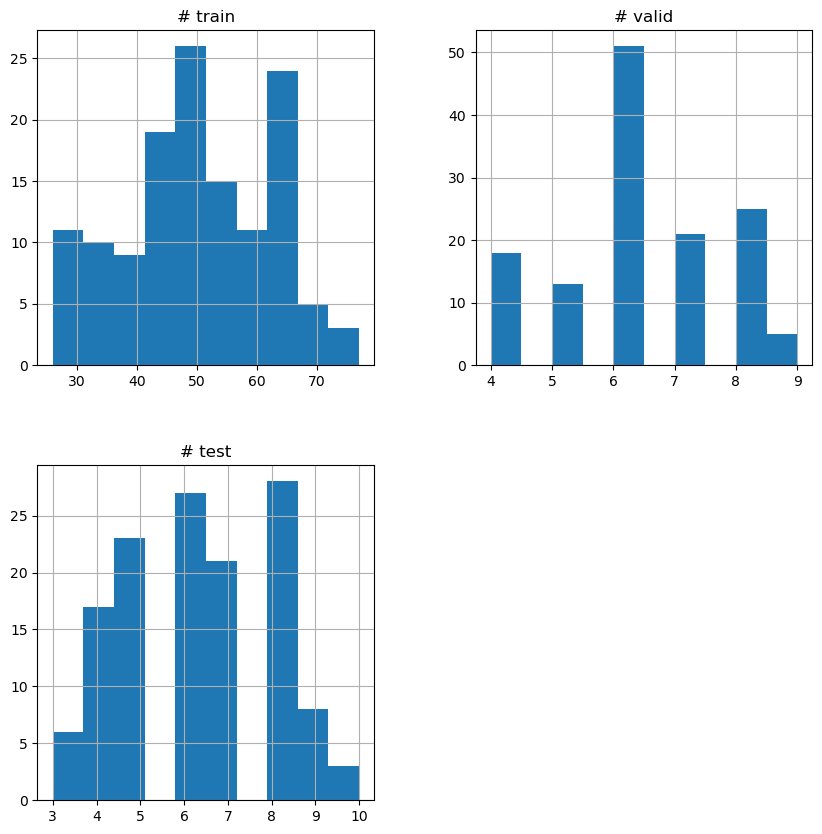

In [7]:
classes = sorted(os.listdir(os.path.join(s3_path, 'train')))
num_train_images = []
num_valid_images = []
num_test_images = []

for _class in classes:
    num_train_images.append(len([file for file in os.listdir(os.path.join(s3_path, 'train', _class))]))
    num_valid_images.append(len([file for file in os.listdir(os.path.join(s3_path, 'valid', _class))]))
    num_test_images.append(len([file for file in os.listdir(os.path.join(s3_path, 'test', _class))]))

df_stats = pd.DataFrame(
    {
        "Dog Breeds " : list(classes),
        "Number for train" : num_train_images,
        "Number for valid" : num_valid_images,
        "Number for test"  : num_test_images
    }
)
df_stats = df_stats.set_index("Dog Breed")

display(df_stats)

print("\n Distribution \n")
print(df_stats.describe())

print("\n  Split distribution \n")
display(df_stats.hist(figsize=(10, 10)))

<AxesSubplot:xlabel='Dog Breed'>

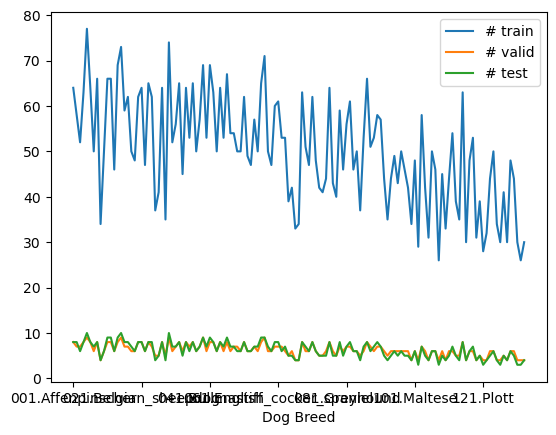

In [8]:
df_stats.plot()

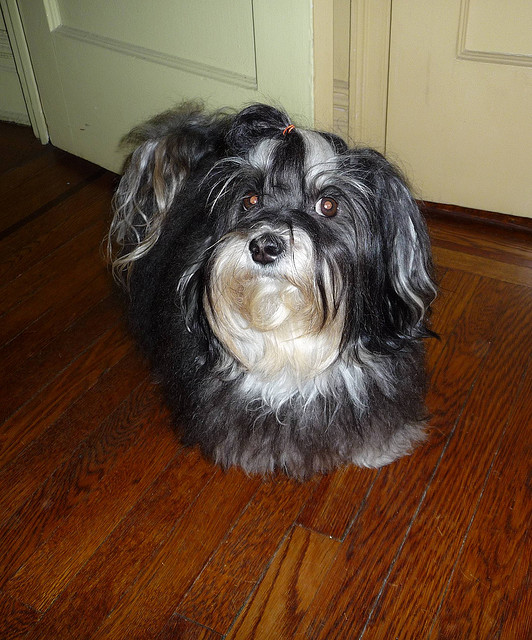

In [10]:
import matplotlib.pyplot as plt
from PIL import Image
import s3fs
import io

fs = s3fs.S3FileSystem()


with fs.open(f's3://sagemaker-us-east-1-477120104741/dog-image-data/test/082.Havanese/Havanese_05571.jpg') as f:
        payload = f.read()
        display(Image.open(io.BytesIO(payload)))
    
plt.show()

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [11]:
# harcode data set directiory path
inputs = 's3://sagemaker-us-east-1-477120104741/dog-image-data/'

In [12]:
# refer to https://sagemaker.readthedocs.io/en/stable/overview.html#prepare-a-training-script
train_path= "s3://{}/{}/{}/".format(bucket, prefix, 'train')
valid_path= "s3://{}/{}/{}/".format(bucket, prefix, 'valid')
test_path= "s3://{}/{}/{}/".format(bucket, prefix, 'test')

s3_output_dir = "s3://{}/{}/".format(bucket, prefix)
s3_model_dir = "s3://{}/{}/".format(bucket, "image_classification/model")

os.environ['SM_CHANNEL_TRAIN']=train_path
os.environ['SM_CHANNEL_VAL']=valid_path
os.environ['SM_CHANNEL_TEST']=test_path
os.environ['SM_MODEL_DIR']=s3_model_dir
os.environ['SM_OUTPUT_DATA_DIR']=s3_output_dir

In [13]:
train_path, valid_path, test_path


('s3://sagemaker-us-east-1-477120104741/dog-image-data/train/',
 's3://sagemaker-us-east-1-477120104741/dog-image-data/valid/',
 's3://sagemaker-us-east-1-477120104741/dog-image-data/test/')

In [14]:
os.environ['SM_MODEL_DIR']

's3://sagemaker-us-east-1-477120104741/image_classification/model/'

In [15]:
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256]),
    "epochs": CategoricalParameter([3, 5, 10, 20])
}

objective_metric_name = "Average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [16]:
#TODO: Create estimators for your HPs

# estimator = # TODO: Your estimator here

# tuner = # TODO: Your HP tuner here

from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type =  'ml.g4dn.2xlarge',
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=1,
    max_parallel_jobs=1,
    objective_type=objective_type,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [17]:
# TODO: Fit your HP Tuner
tuner.fit({"train": inputs }, wait=True) # TODO: Remember to include your data channels
# You can communicate the with the SM_CHANNEL_TRAIN / SM_CHANNEL_VAL / SM_CHANNEL_TEST of os.environ by adding "train", "val" and "test" key, respectively, to the dictionary you pass to fit
# tuner.fit({"train": train_path,
#           "val": valid_path,  # the key has to be "val"
#           "test": test_path
#           }, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
...............................................................................................................................!


In [18]:
tuner.best_training_job()

'pytorch-training-240219-2121-001-d45eb420'

In [19]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2024-02-19 21:30:55 Starting - Preparing the instances for training
2024-02-19 21:30:55 Downloading - Downloading the training image
2024-02-19 21:30:55 Training - Training image download completed. Training in progress.
2024-02-19 21:30:55 Uploading - Uploading generated training model
2024-02-19 21:30:55 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"64"',
 'epochs': '"5"',
 'lr': '0.0013109495042540058',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2024-02-19-21-21-30-505"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-477120104741/pytorch-training-2024-02-19-21-21-30-505/source/sourcedir.tar.gz"'}

from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    CollectionConfig,
    rule_configs,
    ProfilerRule
)## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [20]:
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    CollectionConfig,
    rule_configs,
    ProfilerRule,
    ProfilerConfig,
    FrameworkProfile
)


In [21]:
# TODO: Set up debugging and profiling rules and hooks
hyperparameters={
    'lr':best_estimator.hyperparameters()['lr'],
    'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"',"")),
    'epochs': best_estimator.hyperparameters()['epochs'].strip('"')
}

print(f"\n Best Hyperparamters: \n {hyperparameters}")

# create rules
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]


# add collection_configs to record losses
collection_configs=[CollectionConfig(
    name="CrossEntropyLoss_output_0",
    parameters={"include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

# create debugger hook configuration
debugger_hook_config = DebuggerHookConfig(
    collection_configs=collection_configs,
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=10)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Best Hyperparamters: 
 {'lr': '0.0013109495042540058', 'batch_size': 5, 'epochs': 1}


In [23]:
# TODO: Create and fit an estimator
# https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html
estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="smdebugger-dogImageClassifier",
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.2xlarge",
    py_version="py36",
    framework_version="1.8",
    hyperparameters=hyperparameters,
    rules=rules,
    debugger_hook_config=debugger_hook_config,
    profiler_config=profiler_config
    
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [24]:
 #input_data 
estimator.fit({"train": inputs }, wait=True)


Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: smdebugger-dogImageClassifier-2024-02-19-21-32-30-149


2024-02-19 21:32:30 Starting - Starting the training job...
2024-02-19 21:32:56 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2024-02-19 21:34:22 Downloading - Downloading input data......
2024-02-19 21:35:22 Downloading - Downloading the training image..................
2024-02-19 21:38:23 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-02-19 21:38:40,126 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-02-19 21:38:40,159 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-02-19 21:38:40,161 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-02-19 21:38:4

In [25]:
estimator

In [26]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

print(f"Jobname: {job_name}")
print(f"Client: {client}")
print(f"Description: {description}")

Jobname: smdebugger-dogImageClassifier-2024-02-19-21-32-30-149
Client: <botocore.client.SageMaker object at 0x7f52396befe0>
Description: {'TrainingJobName': 'smdebugger-dogImageClassifier-2024-02-19-21-32-30-149', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:477120104741:training-job/smdebugger-dogImageClassifier-2024-02-19-21-32-30-149', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-477120104741/smdebugger-dogImageClassifier-2024-02-19-21-32-30-149/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '5', 'epochs': '1', 'lr': '"0.0013109495042540058"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"smdebugger-dogImageClassifier-2024-02-19-21-32-30-149"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-477120104741/smdebugger-dogImageClassifier-2024-02-19-21-32-30-149/source/sourcedir.tar.gz"'}, '

In [27]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2024-02-19 21:43:19.742 sagemaker-data-sci-ml-g4dn-2xlarge-4ecd0ca66123a365305b8ceda3e3:649 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-02-19 21:43:19.751 sagemaker-data-sci-ml-g4dn-2xlarge-4ecd0ca66123a365305b8ceda3e3:649 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-477120104741/smdebugger-dogImageClassifier-2024-02-19-21-32-30-149/debug-output


In [28]:
#display tensor names
trial.tensor_names()

[2024-02-19 21:43:21.871 sagemaker-data-sci-ml-g4dn-2xlarge-4ecd0ca66123a365305b8ceda3e3:649 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-02-19 21:43:22.887 sagemaker-data-sci-ml-g4dn-2xlarge-4ecd0ca66123a365305b8ceda3e3:649 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_bn1.bias',
 'gradient/ResNet_bn1.weight',
 'gradient/ResNet_conv1.weight',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'gradient/ResNet_fc.4.bias',
 'gradient/ResNet_fc.4.weight',
 'gradient/ResNet_layer1.0.bn1.bias',
 'gradient/ResNet_layer1.0.bn1.weight',
 'gradient/ResNet_layer1.0.bn2.bias',
 'gradient/ResNet_layer1.0.bn2.weight',
 'gradient/ResNet_layer1.0.bn3.bias',
 'gradient/ResNet_layer1.0.bn3.weight',
 'gradient/ResNet_layer1.0.conv1.weight',
 'gradient/ResNet_layer1.0.conv2.weight',
 'gradient/ResNet_layer1.0.conv3.weight',
 'gradient/ResNet_layer1.0.downsample.0.weight',
 'gradient/ResNet_layer1.0.downsample.1.bias',
 'gradient/ResNet_layer1.0.downsample.1.weight',
 'gradient/ResNet_layer1.1.bn1.bias',
 'gradient/ResNet_layer1.1.bn1.weight',
 'gradient/ResNet_layer1.1.bn2.bias',
 'gradient/ResNet_layer1.1.bn2.weight',
 'gradient/ResNet_layer1.1.bn3

In [29]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

335

In [30]:
#functions to plot the output tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("\nLoaded TRAIN data")
    steps_eval, vals_eval = get_data(trial,
                                     tensor_name, mode=ModeKeys.EVAL)
    print("\nLoaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps for TRAIN")
    par.set_xlabel("Steps for EVAL")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label = tensor_name)
    print("Completed TRAIN plot")
    
    (p2,) = par.plot(steps_eval, vals_eval, label="valid_" + tensor_name)
    print("Completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()
    plt.savefig('cross-entropy.png')

In [ ]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [31]:
# Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print('Profiler report location: {}'.format(rule_output_path))




Profiler report location: s3://sagemaker-us-east-1-477120104741/smdebugger-dogImageClassifier-2024-02-19-21-32-30-149/rule-output


In [32]:
! aws s3 ls {rule_output_path} --recursive

2024-02-19 21:42:48     405735 smdebugger-dogImageClassifier-2024-02-19-21-32-30-149/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-02-19 21:42:48     258727 smdebugger-dogImageClassifier-2024-02-19-21-32-30-149/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-02-19 21:42:43        191 smdebugger-dogImageClassifier-2024-02-19-21-32-30-149/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-02-19 21:42:43       4424 smdebugger-dogImageClassifier-2024-02-19-21-32-30-149/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-02-19 21:42:43       2054 smdebugger-dogImageClassifier-2024-02-19-21-32-30-149/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-02-19 21:42:43        129 smdebugger-dogImageClassifier-2024-02-19-21-32-30-149/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2024-02-19 21:42:43       2223 smdebugger-dogIma

In [33]:
! aws s3 ls {rule_output_path} --recursive

2024-02-19 21:42:48     405735 smdebugger-dogImageClassifier-2024-02-19-21-32-30-149/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-02-19 21:42:48     258727 smdebugger-dogImageClassifier-2024-02-19-21-32-30-149/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-02-19 21:42:43        191 smdebugger-dogImageClassifier-2024-02-19-21-32-30-149/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-02-19 21:42:43       4424 smdebugger-dogImageClassifier-2024-02-19-21-32-30-149/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-02-19 21:42:43       2054 smdebugger-dogImageClassifier-2024-02-19-21-32-30-149/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-02-19 21:42:43        129 smdebugger-dogImageClassifier-2024-02-19-21-32-30-149/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2024-02-19 21:42:43       2223 smdebugger-dogIma

In [34]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

import IPython

# Load the HTML report and display it in the notebook
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [35]:
from IPython.display import HTML, display

def set_background(color):    
    script = (
        "var cell = this.closest('.jp-CodeCell');"
        "var editor = cell.querySelector('.jp-Editor');"
        "editor.style.background='{}';"
        "this.parentNode.removeChild(this)"
    ).format(color)
    
    display(HTML('<img src onerror="{}" style="display:none">'.format(script)))

In [36]:
set_background('honeydew')

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

## Model Deploying

In [45]:
# TODO: Deploy your model to an endpoint
from sagemaker.predictor import Predictor
from sagemaker.pytorch.model import PyTorchModel

model_location = estimator.model_data
model_location

instance_type = "ml.g4dn.2xlarge"
endpoint_name = 'Project_3-' + instance_type.replace(".","-")
role = sagemaker.get_execution_role()
print(endpoint_name)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Project_3-ml-g4dn-2xlarge


In [47]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )

In [48]:
estimator = PyTorchModel(model_data=model_location,
                             role=role,
                             entry_point='inference.py',
                             py_version='py36',
                             framework_version='1.8',
                             predictor_cls = ImagePredictor
                        )
# endpoint
predictor=estimator.deploy(initial_instance_count=1, instance_type=instance_type) 
# TODO: Add your deployment configuration like instance type and number of instances

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-477120104741/smdebugger-dogImageClassifier-2024-02-19-21-32-30-149/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-477120104741/pytorch-inference-2024-02-19-21-54-28-048/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-02-19-21-54-34-801
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-02-19-21-54-35-656
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-02-19-21-54-35-656


----------!

The dog photo used to do the prediction is:


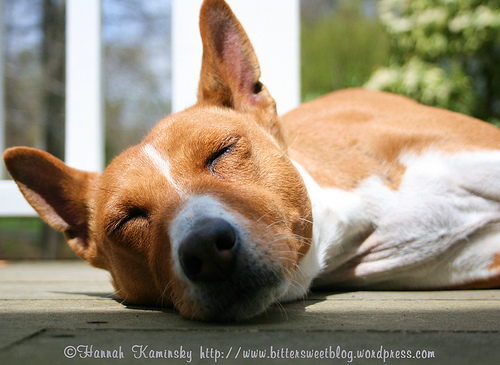

The label of the image is 14
The prediction given by the machine learning model is 8

The dog photo used to do the prediction is:


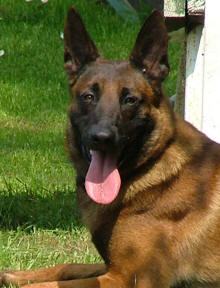

The label of the image is 20
The prediction given by the machine learning model is 20



In [49]:
# TODO: Run an prediction on the endpoint
from PIL import Image
import io
import os
import numpy as np

files = [
    './dogImages/test/014.Basenji/Basenji_00961.jpg',
    './dogImages/test/020.Belgian_malinois/Belgian_malinois_01460.jpg',
    './dogImages/test/082.Havanese/Havanese_05614.jpg',
    './dogImages/test/115.Papillon/Papillon_07498.jpg',
    './dogImages/test/046.Cavalier_king_charles_spaniel/Cavalier_king_charles_spaniel_03291.jpg',
    './dogImages/test/101.Maltese/Maltese_06766.jpg'
    ]

labels = [14, 20, 82, 115, 46, 101] 
    
for i in range(len(files)):
    file = files[i]
    label = labels[i]
    
    # Display image to be predicted
    img = Image.open(file)
    print('The dog photo used for the prediction:')
    display(img)
    

    image = open(file, 'rb').read()
    
    # Query endpoint
    response = predictor.predict(image, initial_args = {'ContentType':'image/jpeg'})
    prediction = np.argmax(response[0]) + 1    
    
    print(f'The label of the image is {label}')
    print(f'The prediction  is {prediction}\n')




In [51]:
#predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.g4dn.2xlarge") # TODO: Add your deployment configuration like instance type and number of instances

In [52]:
img_file_name = "./dogImages/test/024.Bichon_frise/Bichon_frise_01757.jpg"
with open(img_file_name, "rb") as f:
    payload = f.read()
    
type(payload)

bytes

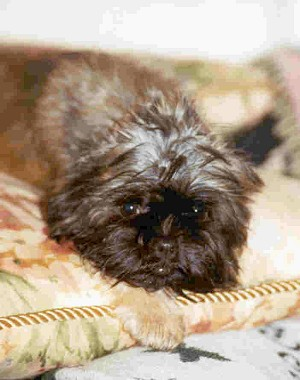

In [53]:
from PIL import Image
import io
Image.open(io.BytesIO(payload))

In [54]:
response=predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
response

[[-0.7290480136871338,
  -8.644608497619629,
  -13.465003967285156,
  -11.06839370727539,
  -16.20528793334961,
  -10.20691204071045,
  -20.65550994873047,
  -14.512118339538574,
  -8.2719144821167,
  -13.318266868591309,
  -15.085232734680176,
  -13.44836139678955,
  -5.418413162231445,
  -17.157024383544922,
  -19.44121551513672,
  -19.737442016601562,
  -5.6064863204956055,
  -14.748490333557129,
  -9.487297058105469,
  -14.901959419250488,
  -7.72752571105957,
  -8.604736328125,
  -17.750194549560547,
  -6.620534896850586,
  -14.831999778747559,
  -4.463028907775879,
  -18.129697799682617,
  -18.951614379882812,
  -13.916638374328613,
  -4.484832763671875,
  -13.806120872497559,
  -16.462310791015625,
  -2.979757308959961,
  -11.648782730102539,
  -8.841666221618652,
  -4.360644340515137,
  -16.831235885620117,
  -1.8410236835479736,
  -14.461262702941895,
  -12.975342750549316,
  -11.210803031921387,
  -2.0841073989868164,
  -14.019754409790039,
  -6.070305824279785,
  -18.2953319

In [55]:
import numpy as np
np.argmax(response, 1)

array([0])

Display Image:


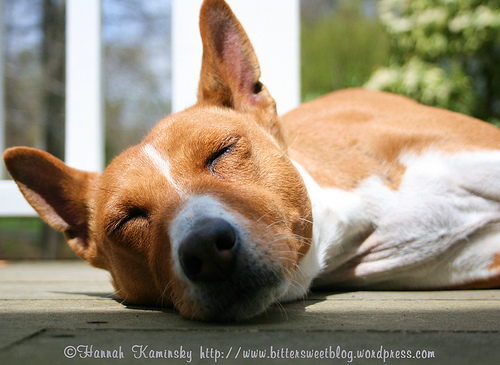

Expected Class: 14
Inference on class: [8] 




In [57]:
from PIL import Image
import io
import os
import numpy as np

test_directory =  "./dogImages/test/024.Bichon_frise/"
test_images = ["Bichon_frise_01760.jpg"]
test_labels = 24

for index in range(len(test_images)):
    
    test_image = test_images[index]
    test_file_path = os.path.join(test_directory, test_image) 
    
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Display Image:")
        display(Image.open(io.BytesIO(payload)))
        print(f"\n\n Expected Label: {test_labels}")
        response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"}) 
        predicted_dog_breed = np.argmax(response, 1) + 1
        print(f"\n\n Inference on label: {predicted_dog_breed} \n\n")

In [59]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2024-02-19-21-54-35-656
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2024-02-19-21-54-35-656
